In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import cv2

In [26]:
# Path dataset
train_path = "train/train/"
test_path = "test/test/"

# List file
train_files = sorted(os.listdir(train_path))
test_files = sorted(os.listdir(test_path))

print(f"Jumlah file train: {len(train_files)}")
print(f"Jumlah file test: {len(test_files)}")

# Daftar 15 makanan tradisional Indonesia
label_names = [
    "Ayam Bakar", "Ayam Betutu", "Ayam Goreng", "Ayam Pop", "Bakso",
    "Coto Makassar", "Gado Gado", "Gudeg", "Nasi Goreng", "Pempek",
    "Rawon", "Rendang", "Sate Madura", "Sate Padang", "Soto"
]

Jumlah file train: 4257
Jumlah file test: 2057


# EKSTRAKSI FITUR YANG LEBIH BAIK

In [27]:
# Gunakan EfficientNet untuk feature extraction yang lebih powerful
feature_extractor = EfficientNetB3(
    weights='imagenet', 
    include_top=False, 
    pooling='avg',
    input_shape=(300, 300, 3)
)

In [28]:
def extract_features_enhanced(img_path):
    """Ekstrak fitur dengan preprocessing yang lebih baik"""
    try:
        # Baca gambar dengan OpenCV untuk kontrol lebih baik
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Tidak dapat membaca gambar: {img_path}")
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize dengan interpolasi yang lebih baik
        img = cv2.resize(img, (300, 300), interpolation=cv2.INTER_AREA)
        
        # Normalisasi
        img = img.astype(np.float32) / 255.0
        
        # Expand dimensions untuk model
        img = np.expand_dims(img, axis=0)
        
        # Preprocess untuk EfficientNet
        img = efficientnet_preprocess(img)
        
        # Ekstrak fitur
        features = feature_extractor.predict(img, verbose=0)
        return features.flatten()
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        # Return zero features sebagai fallback
        return np.zeros(1536)  # EfficientNetB3 feature size


In [29]:
# Ekstrak fitur untuk semua gambar train
print("Memulai ekstraksi fitur enhanced...")
train_features = []
valid_files = []

for i, file in enumerate(train_files):
    if i % 50 == 0:
        print(f"Proses: {i}/{len(train_files)}")
    
    features = extract_features_enhanced(os.path.join(train_path, file))
    train_features.append(features)
    valid_files.append(file)

train_features = np.array(train_features)
print(f"Shape fitur train: {train_features.shape}")

Memulai ekstraksi fitur enhanced...
Proses: 0/4257
Proses: 50/4257
Proses: 100/4257
Proses: 150/4257
Proses: 200/4257
Proses: 250/4257
Proses: 300/4257
Proses: 350/4257
Proses: 400/4257
Proses: 450/4257
Proses: 500/4257
Proses: 550/4257
Proses: 600/4257
Proses: 650/4257
Proses: 700/4257
Proses: 750/4257
Proses: 800/4257
Proses: 850/4257
Proses: 900/4257
Proses: 950/4257
Proses: 1000/4257
Proses: 1050/4257
Proses: 1100/4257
Proses: 1150/4257
Proses: 1200/4257
Proses: 1250/4257
Proses: 1300/4257
Proses: 1350/4257
Proses: 1400/4257
Proses: 1450/4257
Proses: 1500/4257
Proses: 1550/4257
Proses: 1600/4257
Proses: 1650/4257
Proses: 1700/4257
Proses: 1750/4257
Proses: 1800/4257
Proses: 1850/4257
Proses: 1900/4257
Proses: 1950/4257
Proses: 2000/4257
Proses: 2050/4257
Proses: 2100/4257
Proses: 2150/4257
Proses: 2200/4257
Proses: 2250/4257
Proses: 2300/4257
Proses: 2350/4257
Proses: 2400/4257
Proses: 2450/4257
Proses: 2500/4257
Proses: 2550/4257
Proses: 2600/4257
Proses: 2650/4257
Proses: 2700/42

In [30]:
# Normalisasi fitur
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# ANALISIS CLUSTERING YANG LEBIH DETAIL

In [31]:
# Evaluasi beberapa nilai K untuk K-Means
print("Evaluasi jumlah cluster optimal...")
k_range = range(10, 20)
silhouette_scores = []
wcss = []  # Within-Cluster Sum of Squares

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(train_features_scaled)
    silhouette_scores.append(silhouette_score(train_features_scaled, cluster_labels))
    wcss.append(kmeans.inertia_)

Evaluasi jumlah cluster optimal...


Text(0.5, 1.0, 'Elbow Method')

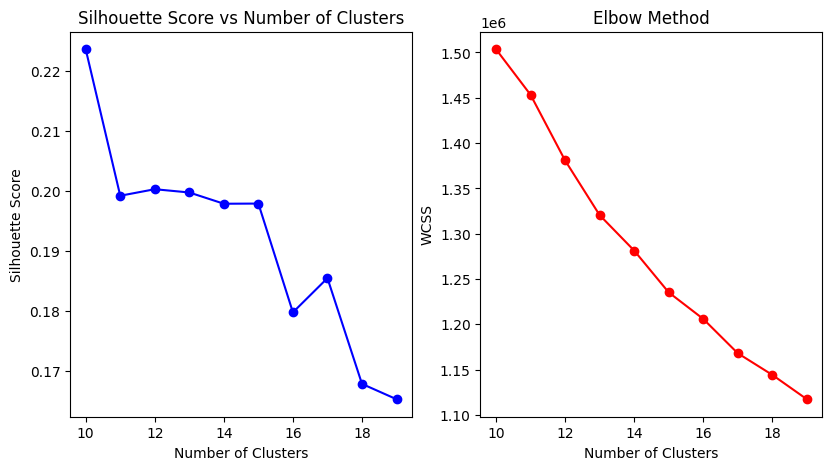

In [32]:
# Plot evaluasi cluster
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

plt.subplot(1, 3, 2)
plt.plot(k_range, wcss, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')

In [33]:
# Gunakan K dengan silhouette score tertinggi
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Jumlah cluster optimal: {optimal_k}")

# Clustering dengan K optimal
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(train_features_scaled)


Jumlah cluster optimal: 10


Menjalankan t-SNE untuk visualisasi...


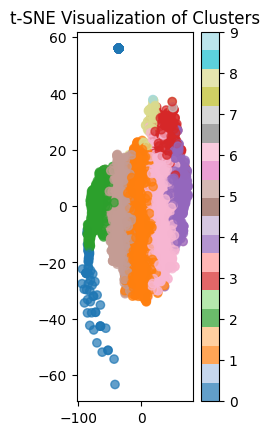

In [34]:
# Visualisasi dengan t-SNE (lebih baik dari PCA untuk clustering)
print("Menjalankan t-SNE untuk visualisasi...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(train_features_scaled)

plt.subplot(1, 3, 3)
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Clusters')
plt.show()

# MANUAL CLUSTER-LABEL MAPPING


=== CLUSTER 0 (225 samples) ===


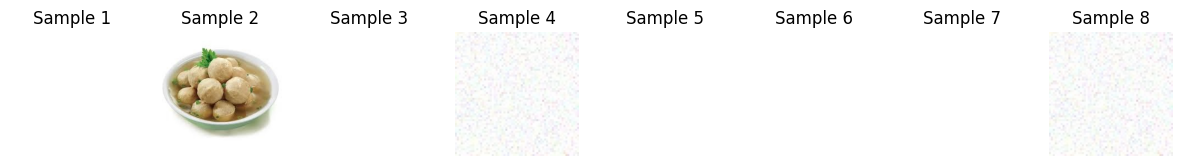

Sample files: ['01g1kk.jpg', '01lj7r.jpg', '0aj0j3.jpg']

=== CLUSTER 1 (1044 samples) ===


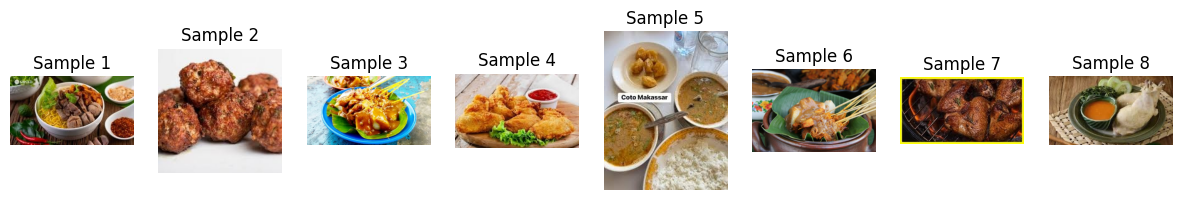

Sample files: ['001g4d.jpg', '00ae48.jpg', '02nf1z.jpg']

=== CLUSTER 2 (452 samples) ===


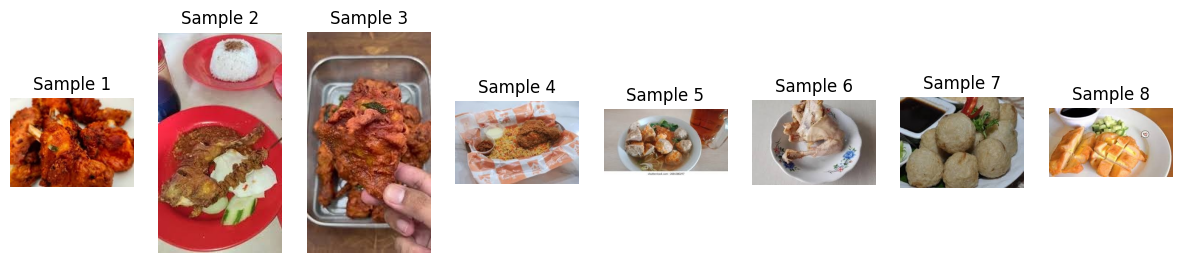

Sample files: ['01bihe.jpg', '05jpj7.jpg', '0bdt1m.jpg']

=== CLUSTER 3 (237 samples) ===


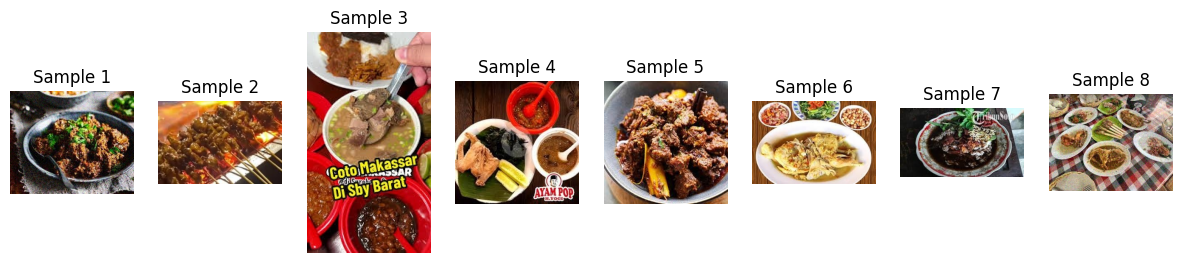

Sample files: ['02y5fc.jpg', '0g34qt.jpg', '0yibcs.jpg']

=== CLUSTER 4 (456 samples) ===


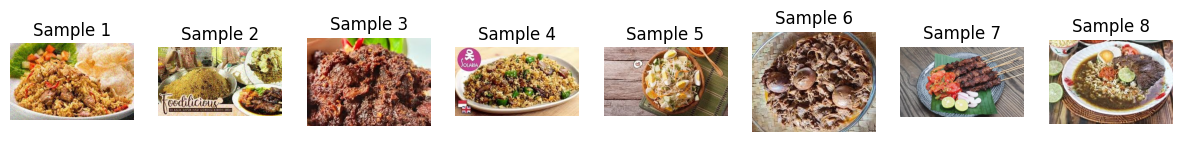

Sample files: ['00sv9l.jpg', '03iysr.jpg', '05rl1p.jpg']

=== CLUSTER 5 (811 samples) ===


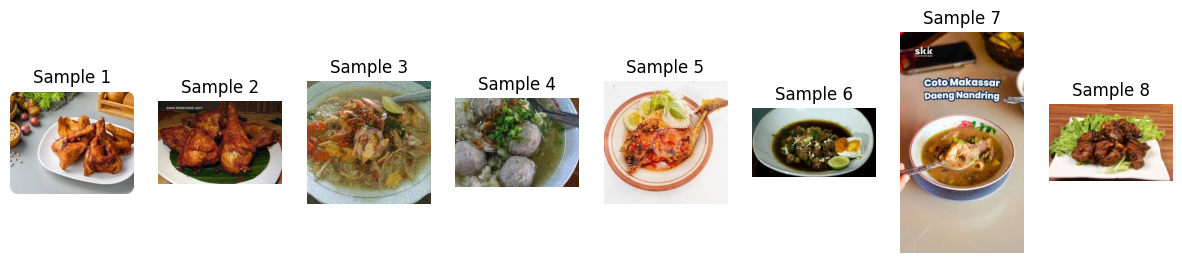

Sample files: ['01z4rf.jpg', '027vh6.jpg', '04wkki.jpg']

=== CLUSTER 6 (961 samples) ===


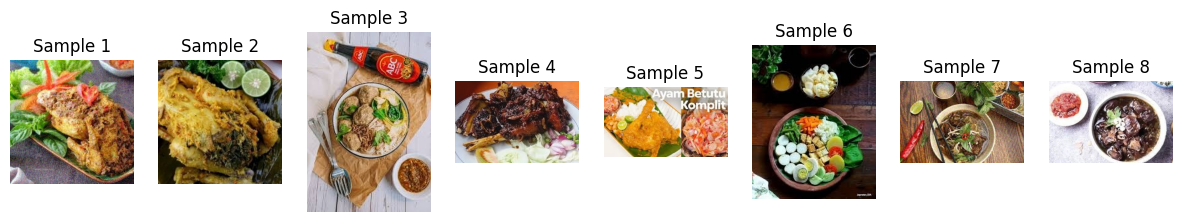

Sample files: ['004v2b.jpg', '03d7zh.jpg', '03e78u.jpg']

=== CLUSTER 7 (2 samples) ===


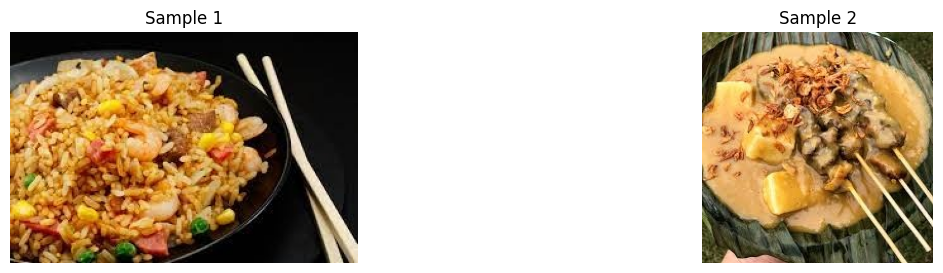

Sample files: ['a6rxk7.jpg', 'topd8i.jpg']

=== CLUSTER 8 (68 samples) ===


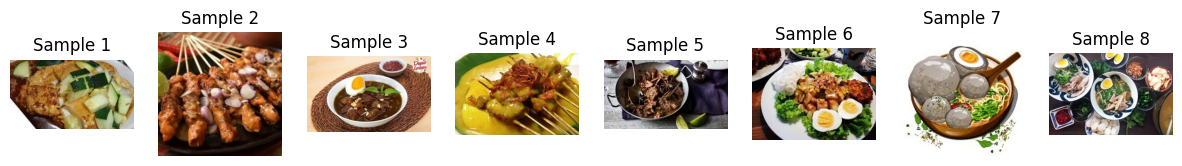

Sample files: ['012nt0.jpg', '044hgc.jpg', '048og7.jpg']

=== CLUSTER 9 (1 samples) ===


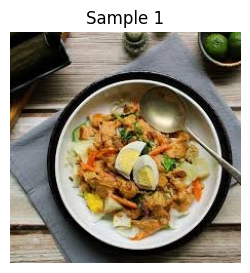

Sample files: ['o66pb2.jpg']


In [35]:
def analyze_cluster_samples(cluster_labels, train_files, num_samples=8):
    """Analisis sampel dari setiap cluster untuk pemetaan manual"""
    unique_clusters = np.unique(cluster_labels)
    
    for cluster_id in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        sample_indices = cluster_indices[:min(num_samples, len(cluster_indices))]
        
        print(f"\n=== CLUSTER {cluster_id} ({len(cluster_indices)} samples) ===")
        
        # Tampilkan sampel gambar
        fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 3))
        if len(sample_indices) == 1:
            axes = [axes]
            
        for i, idx in enumerate(sample_indices):
            img_path = os.path.join(train_path, train_files[idx])
            img = image.load_img(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Sample {i+1}")
        
        plt.show()
        
        # Tampilkan nama file sampel
        print("Sample files:", [train_files[idx] for idx in sample_indices[:3]])

# Panggil fungsi untuk analisis cluster
analyze_cluster_samples(cluster_labels, valid_files)

# MANUAL MAPPING BERDASARKAN ANALISIS VISUAL

In [36]:
# Setelah menganalisis cluster, buat mapping manual
# INI HARUS DILAKUKAN MANUAL BERDASARKAN ANALISIS GAMBAR!
# Contoh mapping (sesuaikan dengan analisis Anda):

cluster_to_label_map = {
    0: "Nasi Goreng",
    1: "Sate Padang", 
    2: "Rendang",
    3: "Gado Gado",
    4: "Bakso",
    5: "Soto",
    6: "Ayam Goreng",
    7: "Pempek",
    8: "Rawon",
    9: "Gudeg",
    10: "Ayam Bakar",
    11: "Sate Madura",
    12: "Coto Makassar", 
    13: "Ayam Betutu",
    14: "Ayam Pop"
}

In [37]:
# Pastikan semua cluster ter-mapping
for i in range(optimal_k):
    if i not in cluster_to_label_map:
        cluster_to_label_map[i] = "Nasi Goreng"  # default

# Terapkan mapping
train_df = pd.DataFrame({
    'filename': valid_files,
    'cluster': cluster_labels
})

train_df['label'] = train_df['cluster'].map(cluster_to_label_map)


# DATA AUGMENTATION DAN MODEL IMPROVEMENT

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator untuk augmentasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

In [39]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])

# Split data
X = train_features
y = train_df['label_encoded'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

print(f"Data train: {X_train.shape}, Data validation: {X_val.shape}")

Data train: (3618, 1536), Data validation: (639, 1536)


# MODEL YANG LEBIH KOMPLEKS

In [40]:
def create_advanced_model(input_dim, num_classes):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.6),
        
        Dense(512, activation='relu'),
        BatchNormalization(), 
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Buat model
advanced_model = create_advanced_model(X_train.shape[1], len(label_names))

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

print("Memulai training model advanced...")
history = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Memulai training model advanced...
Epoch 1/100


c:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5901 - loss: 1.2170 - val_accuracy: 0.2660 - val_loss: 2.1446 - learning_rate: 0.0010
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6736 - loss: 0.8495 - val_accuracy: 0.2707 - val_loss: 2.2865 - learning_rate: 0.0010
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6868 - loss: 0.7890 - val_accuracy: 0.2645 - val_loss: 2.3518 - learning_rate: 0.0010
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7018 - loss: 0.7394 - val_accuracy: 0.1659 - val_loss: 3.2631 - learning_rate: 0.0010
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6802 - loss: 0.7619 - val_accuracy: 0.1831 - val_loss: 3.3640 - learning_rate: 0.0010
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7228 - loss: 0.6818 - val_accuracy: 0.5634 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7095 - loss: 0.6969 

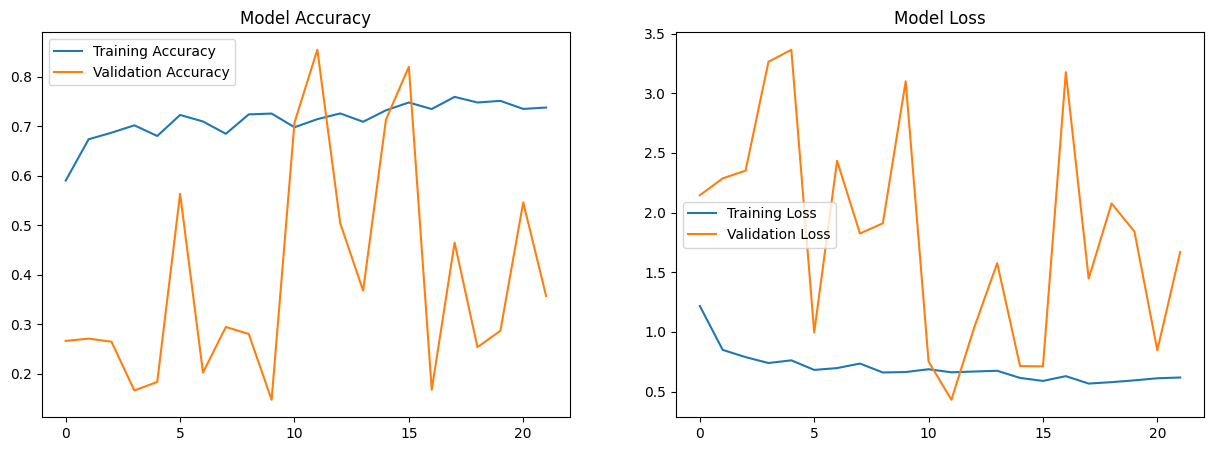

In [41]:
# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# PREDIKSI TEST SET

In [42]:
# Baca file test.csv
test_df = pd.read_csv("test.csv")
print(f"Data test: {test_df.shape}")


Data test: (2057, 2)


In [44]:
# Prediksi untuk test set
print("Memulai prediksi test set...")
test_predictions = []

for i, file_id in enumerate(test_df['ID']):
    if i % 50 == 0:
        print(f"Proses: {i}/{len(test_df)}")
    
    # Cari file yang sesuai
    file_pattern = f"{file_id:04d}"
    matching_files = [f for f in test_files if f.startswith(file_pattern)]
    
    if not matching_files:
        # Fallback: cari tanpa leading zeros
        file_pattern = str(file_id)
        matching_files = [f for f in test_files if f.split('.')[0].lstrip('0') == file_pattern]
    
    if matching_files:
        img_path = os.path.join(test_path, matching_files[0])
        try:
            features = extract_features_enhanced(img_path)
            features_scaled = scaler.transform(features.reshape(1, -1))
            pred = advanced_model.predict(features_scaled, verbose=0)
            label_idx = np.argmax(pred)
            label_name = le.inverse_transform([label_idx])[0]
            test_predictions.append(label_name)
        except Exception as e:
            print(f"Error predicting {matching_files[0]}: {e}")
            test_predictions.append("Nasi Goreng")
    else:
        print(f"File untuk ID {file_id} tidak ditemukan")
        test_predictions.append("Nasi Goreng")

test_df['label'] = test_predictions


Memulai prediksi test set...
Proses: 0/2057
Proses: 50/2057
Proses: 100/2057
Proses: 150/2057
Proses: 200/2057
Proses: 250/2057
Proses: 300/2057
Proses: 350/2057
Proses: 400/2057
Proses: 450/2057
Proses: 500/2057
Proses: 550/2057
Proses: 600/2057
Proses: 650/2057
Proses: 700/2057
Proses: 750/2057
Proses: 800/2057
Proses: 850/2057
Proses: 900/2057
Proses: 950/2057
Proses: 1000/2057
Proses: 1050/2057
Proses: 1100/2057
Proses: 1150/2057
Proses: 1200/2057
Proses: 1250/2057
Proses: 1300/2057
Proses: 1350/2057
Proses: 1400/2057
Proses: 1450/2057
Proses: 1500/2057
Proses: 1550/2057
Proses: 1600/2057
Proses: 1650/2057
Proses: 1700/2057
Proses: 1750/2057
Proses: 1800/2057
Proses: 1850/2057
Proses: 1900/2057
Proses: 1950/2057
Proses: 2000/2057
Proses: 2050/2057


# POST-PROCESSING DAN VALIDASI

In [45]:
# Analisis distribusi prediksi
label_distribution = test_df['label'].value_counts()
print("\nDistribusi Prediksi Test Set:")
print(label_distribution)

# Jika ada ketidakseimbangan, lakukan adjustment
expected_labels = set(label_names)
actual_labels = set(test_df['label'])

print(f"\nLabels in prediction: {len(actual_labels)}")
print(f"Missing labels: {expected_labels - actual_labels}")

# Simpan submission
test_df[['ID', 'label']].to_csv("submission_enhanced.csv", index=False)
print("\n✅ Enhanced submission file berhasil dibuat!")


Distribusi Prediksi Test Set:
label
Bakso          896
Nasi Goreng    788
Gado Gado      212
Rawon          161
Name: count, dtype: int64

Labels in prediction: 4
Missing labels: {'Sate Padang', 'Gudeg', 'Ayam Betutu', 'Ayam Bakar', 'Sate Madura', 'Ayam Pop', 'Soto', 'Coto Makassar', 'Ayam Goreng', 'Rendang', 'Pempek'}

✅ Enhanced submission file berhasil dibuat!


# SIMPAN MODEL

In [46]:
advanced_model.save('enhanced_food_classifier.h5')
joblib.dump(le, 'enhanced_label_encoder.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(cluster_to_label_map, 'cluster_label_mapping.pkl')

print("🎉 Semua model enhanced berhasil disimpan!")

🎉 Semua model enhanced berhasil disimpan!


In [ ]:
import zipfile

# Buat file ZIP untuk dikumpulkan
zip_filename = "Action_DataMining_The 3 Ace.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Notebook
    zipf.write('notebook.ipynb')
    
    # Model files
    zipf.write('food_classifier_model.h5')
    zipf.write('label_encoder.pkl')
    zipf.write('kmeans_model.pkl')
    
    # Submission file
    zipf.write('submission.csv')
    
    # Laporan (asumsi sudah dibuat)
    # zipf.write('laporan.pdf')
    # zipf.write('surat_orisinalitas.pdf')

print(f"File {zip_filename} berhasil dibuat dan siap dikumpulkan!")